In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import datasets

In [8]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16,shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.pool = nn.MaxPool2d(3, 2)
        self.conv1 = nn.Conv2d(3,96,11,4)
        self.conv2 = nn.Conv2d(96,256,5,padding=2)
        self.conv3 = nn.Conv2d(256,384,3,padding=1)
        self.conv4 = nn.Conv2d(384,384,3,padding=1)
        self.conv5 = nn.Conv2d(384,256,3,padding=1)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
        self.dropout = nn.Dropout(p=0.5)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0),256*6*6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
 
 
 
model = AlexNet()
print(model)
if train_on_gpu:
    model.cuda()


AlexNet(
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


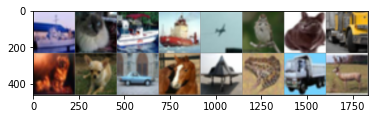

 ship   cat  ship  ship airplane  bird   cat truck   dog   dog automobile horse airplane  frog truck  deer


In [12]:
import torchvision
import matplotlib.pyplot as plt
def imshow(img):
    img = img/2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()
 
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(16)))


In [26]:
import torch.optim as optim
device = torch.device("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 #model was already trained for 5 epochs
for epoch in range(2):
 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, lables = data
        inputs = inputs.to(device)
        lables = lables.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(trainloader)}")
 
print('Finished Training')

Training loss: 0.6973493232369423
Training loss: 0.5907083218359948
Finished Training


In [27]:
torch.save(model, './model')
 
model = torch.load('./model')
print(model)

AlexNet(
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 50000 train images: %d %%'%(100*correct/total))
 


Accuracy of the network on the 50000 train images: 83 %


In [29]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%'%(100*correct/total))


Accuracy of the network on the 10000 test images: 77 %
